# Feb 14th, 2022 (pruned in grp)

**Motivation**: Pruned now part of group.  Easier plotting.  This update closely shadows update from Feb 4th.  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.65), 'bold-lite': rocket(0.6)}

props_base = {
    'num_k': 5,
    'perc': 'p10-sample',
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

## Prepare

In [3]:
fig_dir = pjoin(tmp_dir, 'fig_proportion')
os.makedirs(fig_dir, exist_ok=True)

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_base).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

ids

[0, 1, 2, 3, 4]

## Membership plot

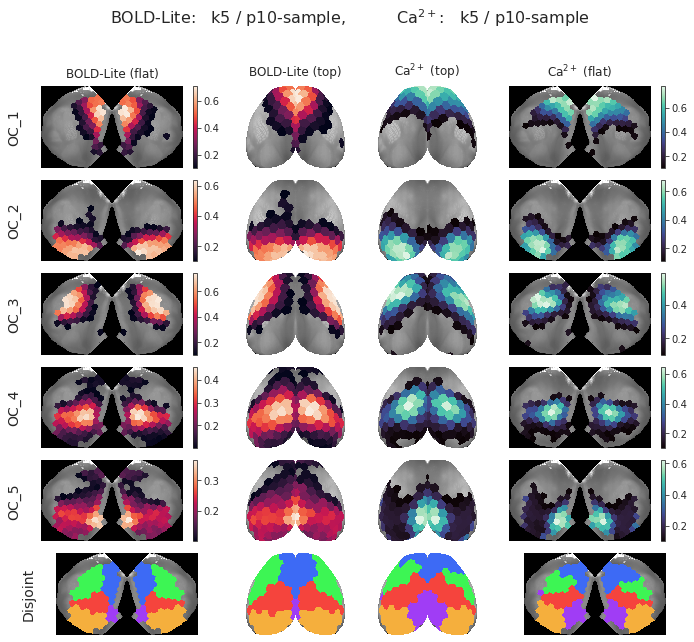

In [5]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [6]:
ovp, disj = gr_bold.pi_symmetry_score(decimals=5)
print(f"BOLD   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5)
print(f"Ca2    : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

BOLD   : : :   ovp: 0.9943,  disj: 0.9816

Ca2    : : :   ovp: 0.9874,  disj: 0.9494

## Plots: group

### BOLD-Lite

In [7]:
i, j, k = gr_bold.run_pi.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

b_grp = bootstrap(
    x=gr_bold.run_cut_prune,
    n_resamples=int(1e6),
    batch=5,
    dims=dims,
    est=None,
)
b_grp = bn.nanmean(bn.nanmean(bn.nanmean(b_grp, 3), 2), 1)
se_boot = bn.nanstd(b_grp, 0, ddof=1)

In [8]:
df_bold = gr_bold.mk_boot_df(se_boot, gr_bold.anim_cut_prune)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/group_bold-lite_(2022_02_14).pdf

done.

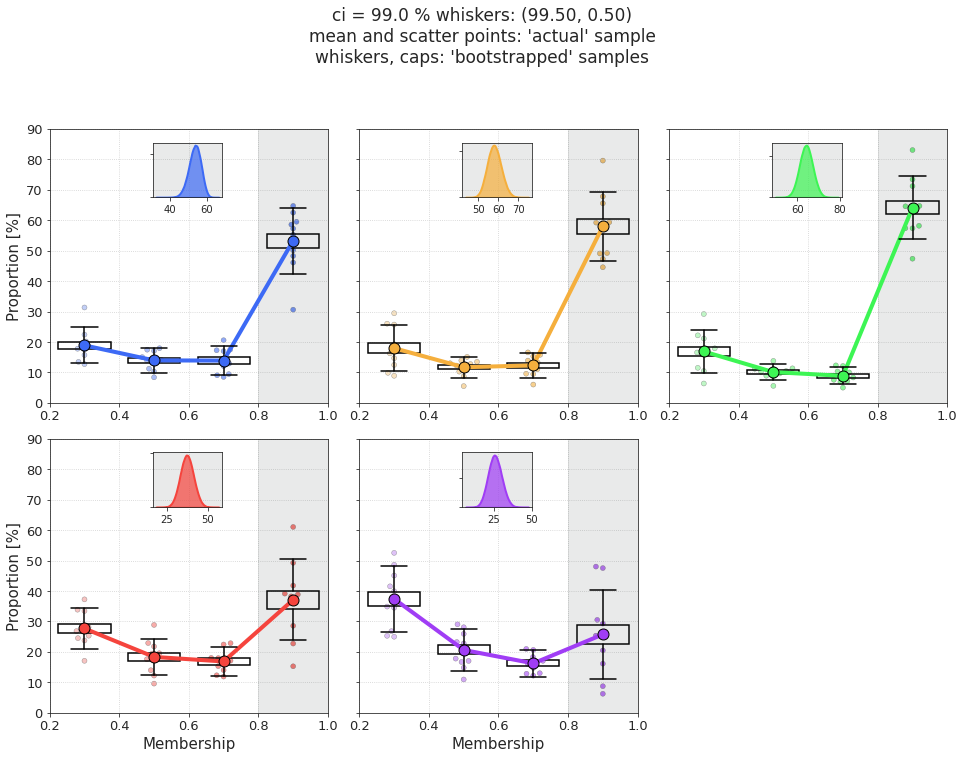

In [9]:
figs, sups, axes, axes_inset = plot_proportions(
    df=df_bold,
    inset_data=b_grp[..., -1].T,
    save_file=pjoin(fig_dir, f"group_bold-lite_{now()}.pdf"),
    ylim=(0, 90),
)
figs[1]

### Ca2+

In [10]:
b_grp = bootstrap(
    x=gr_ca.run_cut_prune,
    n_resamples=int(1e6),
    batch=5,
    dims=dims,
    est=None,
)
b_grp = bn.nanmean(bn.nanmean(bn.nanmean(b_grp, 3), 2), 1)
se_boot = bn.nanstd(b_grp, 0, ddof=1)

In [11]:
df_ca = gr_ca.mk_boot_df(se_boot, gr_ca.anim_cut_prune)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/group_ca2_(2022_02_14).pdf

done.

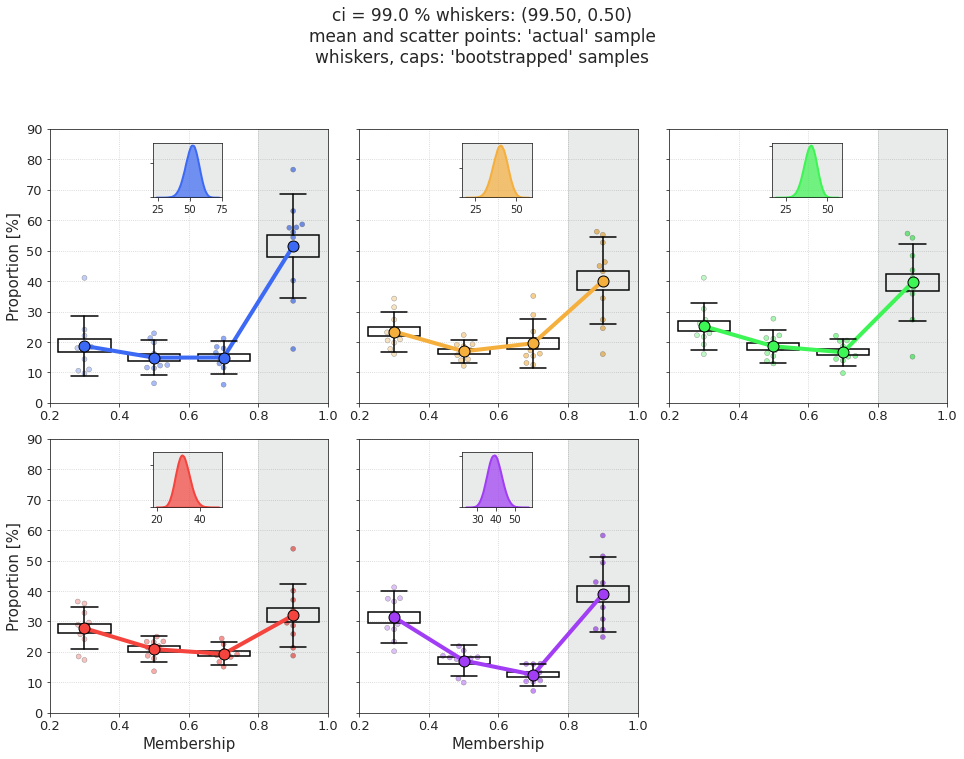

In [12]:
figs, sups, axes, axes_inset = plot_proportions(
    df=df_ca,
    inset_data=b_grp[..., -1].T,
    save_file=pjoin(fig_dir, f"group_ca2_{now()}.pdf"),
    ylim=(0, 90),
)
figs[1]

### BOLD + Ca2

In [16]:
df = pd.concat([df_bold, df_ca])
df.reset_index(inplace=True)
save_obj(
    obj=df,
    file_name='data_group_joyneel',
    save_dir=tmp_dir,
    mode='df',
)

[PROGRESS] 'data_group_joyneel.df' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

'/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/data_group_joyneel.df'

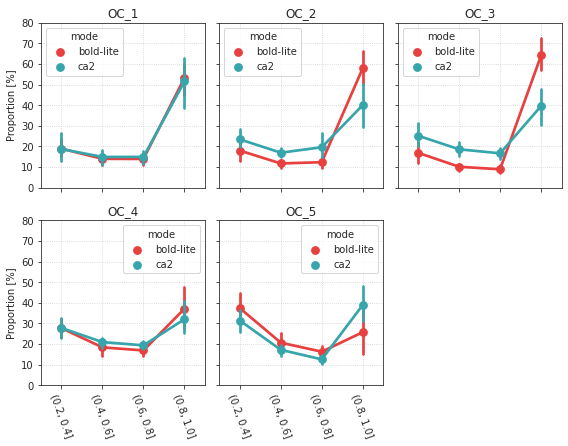

In [17]:
fig, axes = create_figure(2, 3, (8, 6.3), 'all', 'all')

oc_idxs = df['oc_idx'].unique()
for ax, i in zip(axes.flat, oc_idxs):
    sns.pointplot(
        data=df.loc[df['oc_idx'] == i],
        x='interval',
        y='mean',
        hue='mode',
        ci=99,
        palette=pal,
        ax=ax,
    )
    if i in [1, 4]:
        ylbl = 'Proportion [%]'
    else:
        ylbl = ''
    ax.set_ylabel(ylbl)
    ax.set_title(f'OC_{i}')
    ax.tick_params(axis='x', rotation=-70)
    ax.set_xlabel('')
    ax.set_ylim(0, 80)
    ax.grid()
trim_axs(axes, len(oc_idxs))
fig.savefig(pjoin(fig_dir, 'group_bold+ca2.pdf'), bbox_inches='tight')
plt.show()

## Plots: individual

### BOLD-Lite

In [20]:
b_anim = bootstrap(
    x=gr_bold.run_cut_prune,
    n_resamples=int(1e6),
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_boot = bn.nanstd(b_anim, 0, ddof=1)

In [21]:
df_bold = gr_bold.mk_boot_df(se_boot, gr_bold.run_cut_prune, group=False)

In [22]:
for anim in range(10):
    figs, sups, axes, axes_inset = plot_proportions(
        df=df_bold.loc[df_bold['subject'] == anim + 1],
        inset_data=b_anim[:, anim, :, -1].T,
        save_file=pjoin(fig_dir, f"indiv_bold-lite_{mice.get_key(anim + 1)}_{now()}.pdf"),
        ylim=(0, 100),
    );

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC01_(2022_02_14).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC02_(2022_02_14).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC03_(2022_02_14).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC04_(2022_02_14).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC05_(2022_02_14).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC06_(2022_02_14).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC07_(2022_02_14).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC08_(2022_02_14).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC09_(2022_02_14).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC10_(2022_02_14).p
df

done.

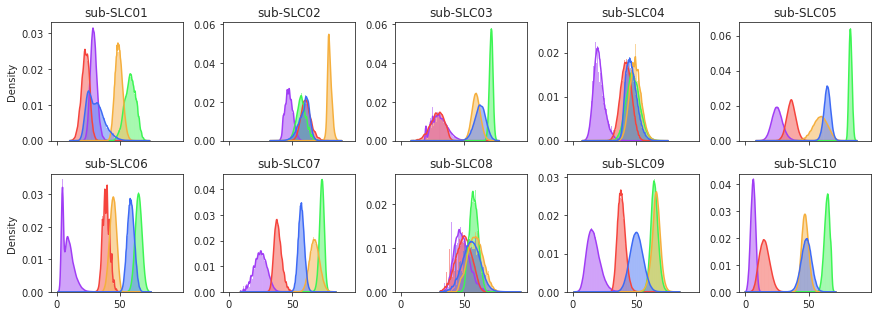

In [23]:
fig, axes = create_figure(2, 5, (12.3, 4.5), sharex='all')
for i in range(10):
    ax = axes.flat[i]
    sns.histplot(
        b_anim[:, i, :, -1],
        palette=gr_bold.colors.values(),
        stat='density',
        legend=False,
        kde=True,
        ax=ax,
    )
    ax.set_title(mice.get_key(i + 1))
    if i % 5 != 0:
        ax.set_ylabel('')
        
plt.show()

In [24]:
for anim in range(10):
    fig, axes = create_figure(5, 3, (10, 16), 'all', 'all')
    for i in range(5):
        for j in range(3):
            a = 1 + 4 * j
            b = 1 + 4 * (j + 1)
            _df = df_bold.loc[
                (df_bold['subject'] == anim + 1) &
                (df_bold['run'].isin(range(a, b))) &
                (df_bold['oc_idx'] == i + 1)
            ]
            ax = axes[i, j]
            sns.pointplot(
                data=_df,
                x='interval',
                y='mean',
                hue='run',
                palette='muted',
                ax=ax,
            )
            if i == 0:
                t = f"Session {j + 1}"
                ax.set_title(t, fontsize=15, y=1.05)
            if j % 3 == 0:
                ylbl = 'Proportion [%]'
            else:
                ylbl = ''
            ax.set_ylabel(ylbl, fontsize=14)

            if j == 2:
                axtw = ax.twinx()
                axtw.set_ylabel(f"OC_{i + 1}", fontsize=15, rotation=-90, labelpad=30)
                axtw.yaxis.set_label_position("right")
                axtw.set_yticks([])

            ax.tick_params(axis='x', rotation=-70)
            ax.set_xlabel('')
            ax.grid()
    fig.savefig(pjoin(fig_dir, f'runs_bold-lite_{mice.get_key(anim + 1)}_{now()}.pdf'), bbox_inches='tight')
    plt.close()

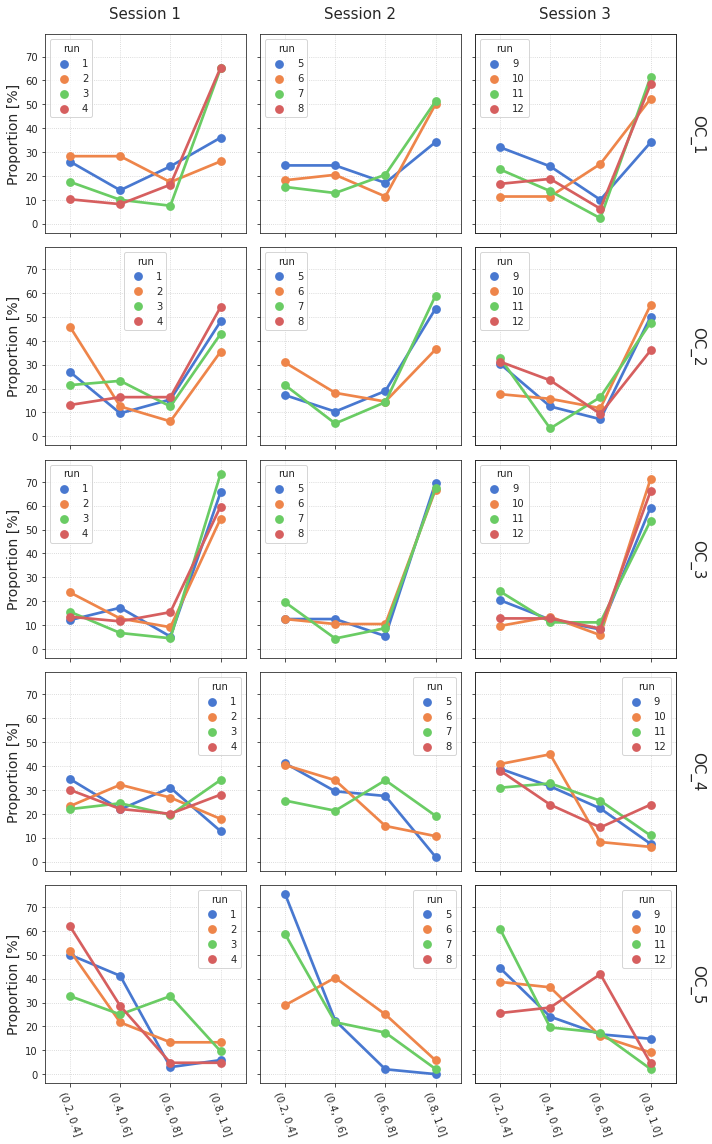

In [25]:
fig

### Ca2+

In [26]:
b_anim = bootstrap(
    x=gr_ca.run_cut_prune,
    n_resamples=int(1e6),
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_boot = bn.nanstd(b_anim, 0, ddof=1)

In [27]:
np.isnan(gr_ca.run_cut_prune).sum(-1).sum(-1).reshape(len(gr_ca.run_cut_prune), -1)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [28]:
df_ca = gr_ca.mk_boot_df(se_boot, gr_ca.run_cut_prune, group=False)

In [29]:
for anim in range(10):
    figs, sups, axes, axes_inset = plot_proportions(
        df=df_ca.loc[df_ca['subject'] == anim + 1],
        inset_data=b_anim[:, anim, :, -1].T,
        save_file=pjoin(fig_dir, f"indiv_ca2_{mice.get_key(anim + 1)}_{now()}.pdf"),
        ylim=(0, 100),
    )

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC01_(2022_02_14).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC02_(2022_02_14).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC03_(2022_02_14).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC04_(2022_02_14).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC05_(2022_02_14).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC06_(2022_02_14).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC07_(2022_02_14).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC08_(2022_02_14).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC09_(2022_02_14).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC10_(2022_02_14).pdf

done.

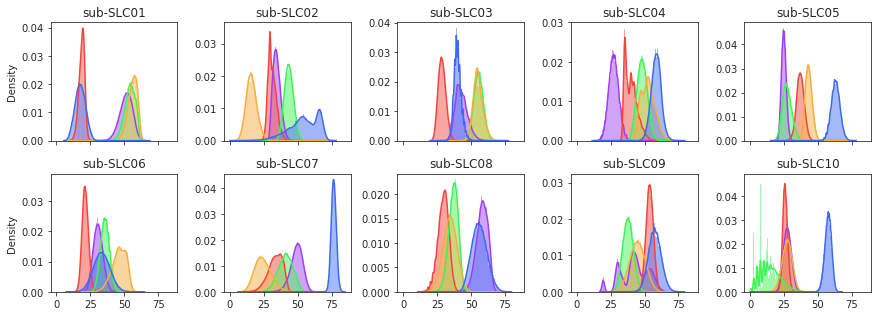

In [30]:
fig, axes = create_figure(2, 5, (12.3, 4.5), sharex='all')
for i in range(10):
    ax = axes.flat[i]
    sns.histplot(
        b_anim[:, i, :, -1],
        palette=gr_ca.colors.values(),
        stat='density',
        legend=False,
        kde=True,
        ax=ax,
    )
    ax.set_title(mice.get_key(i + 1))
    if i % 5 != 0:
        ax.set_ylabel('')

plt.show()

In [31]:
for anim in range(10):
    fig, axes = create_figure(5, 3, (10, 16), 'all', 'all')
    for i in range(5):
        for j in range(3):
            a = 1 + 4 * j
            b = 1 + 4 * (j + 1)
            _df = df_ca.loc[
                (df_ca['subject'] == anim + 1) &
                (df_ca['run'].isin(range(a, b))) &
                (df_ca['oc_idx'] == i + 1)
            ]
            ax = axes[i, j]
            sns.pointplot(
                data=_df,
                x='interval',
                y='mean',
                hue='run',
                palette='muted',
                ax=ax,
            )
            if i == 0:
                t = f"Session {j + 1}"
                ax.set_title(t, fontsize=15, y=1.05)
            if j % 3 == 0:
                ylbl = 'Proportion [%]'
            else:
                ylbl = ''
            ax.set_ylabel(ylbl, fontsize=14)

            if j == 2:
                axtw = ax.twinx()
                axtw.set_ylabel(f"OC_{i + 1}", fontsize=15, rotation=-90, labelpad=30)
                axtw.yaxis.set_label_position("right")
                axtw.set_yticks([])

            ax.tick_params(axis='x', rotation=-70)
            ax.set_xlabel('')
            ax.grid()
    fig.savefig(pjoin(fig_dir, f'runs_ca2_{mice.get_key(anim + 1)}_{now()}.pdf'), bbox_inches='tight')
    plt.close()

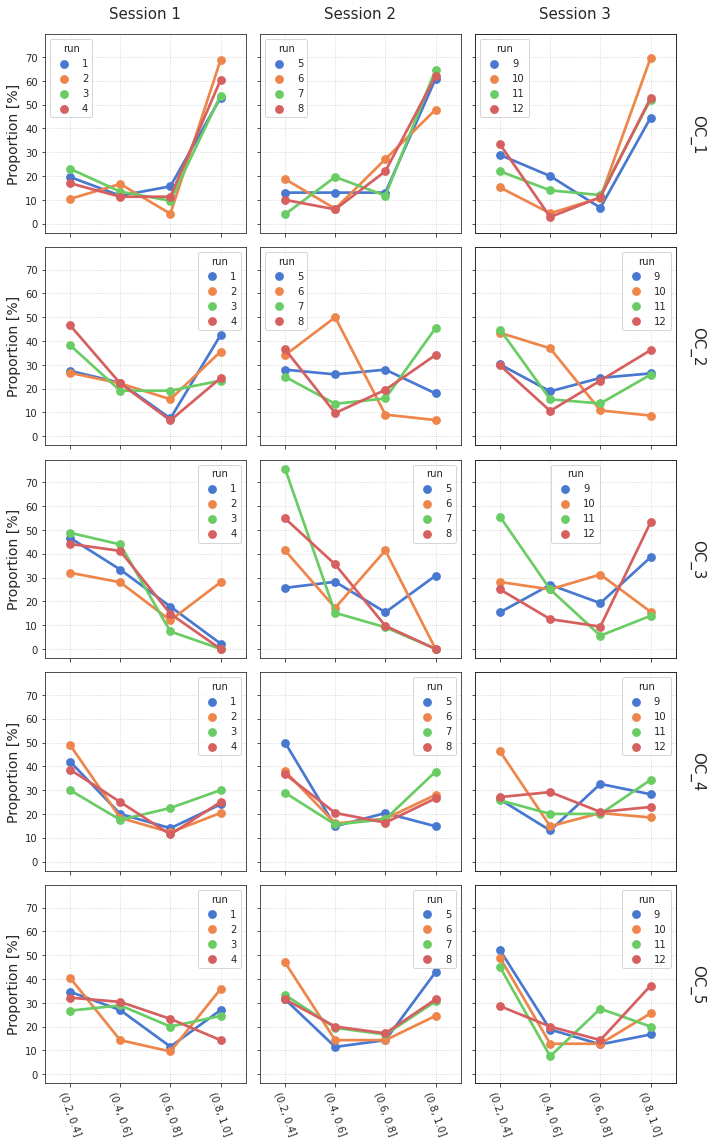

In [32]:
fig

### BOLD + Ca2

In [33]:
df = pd.concat([df_bold, df_ca])
df.reset_index(inplace=True)
save_obj(
    obj=df,
    file_name='data_indiv_joyneel',
    save_dir=tmp_dir,
    mode='df',
)

[PROGRESS] 'data_indiv_joyneel.df' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

'/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/data_indiv_joyneel.df'

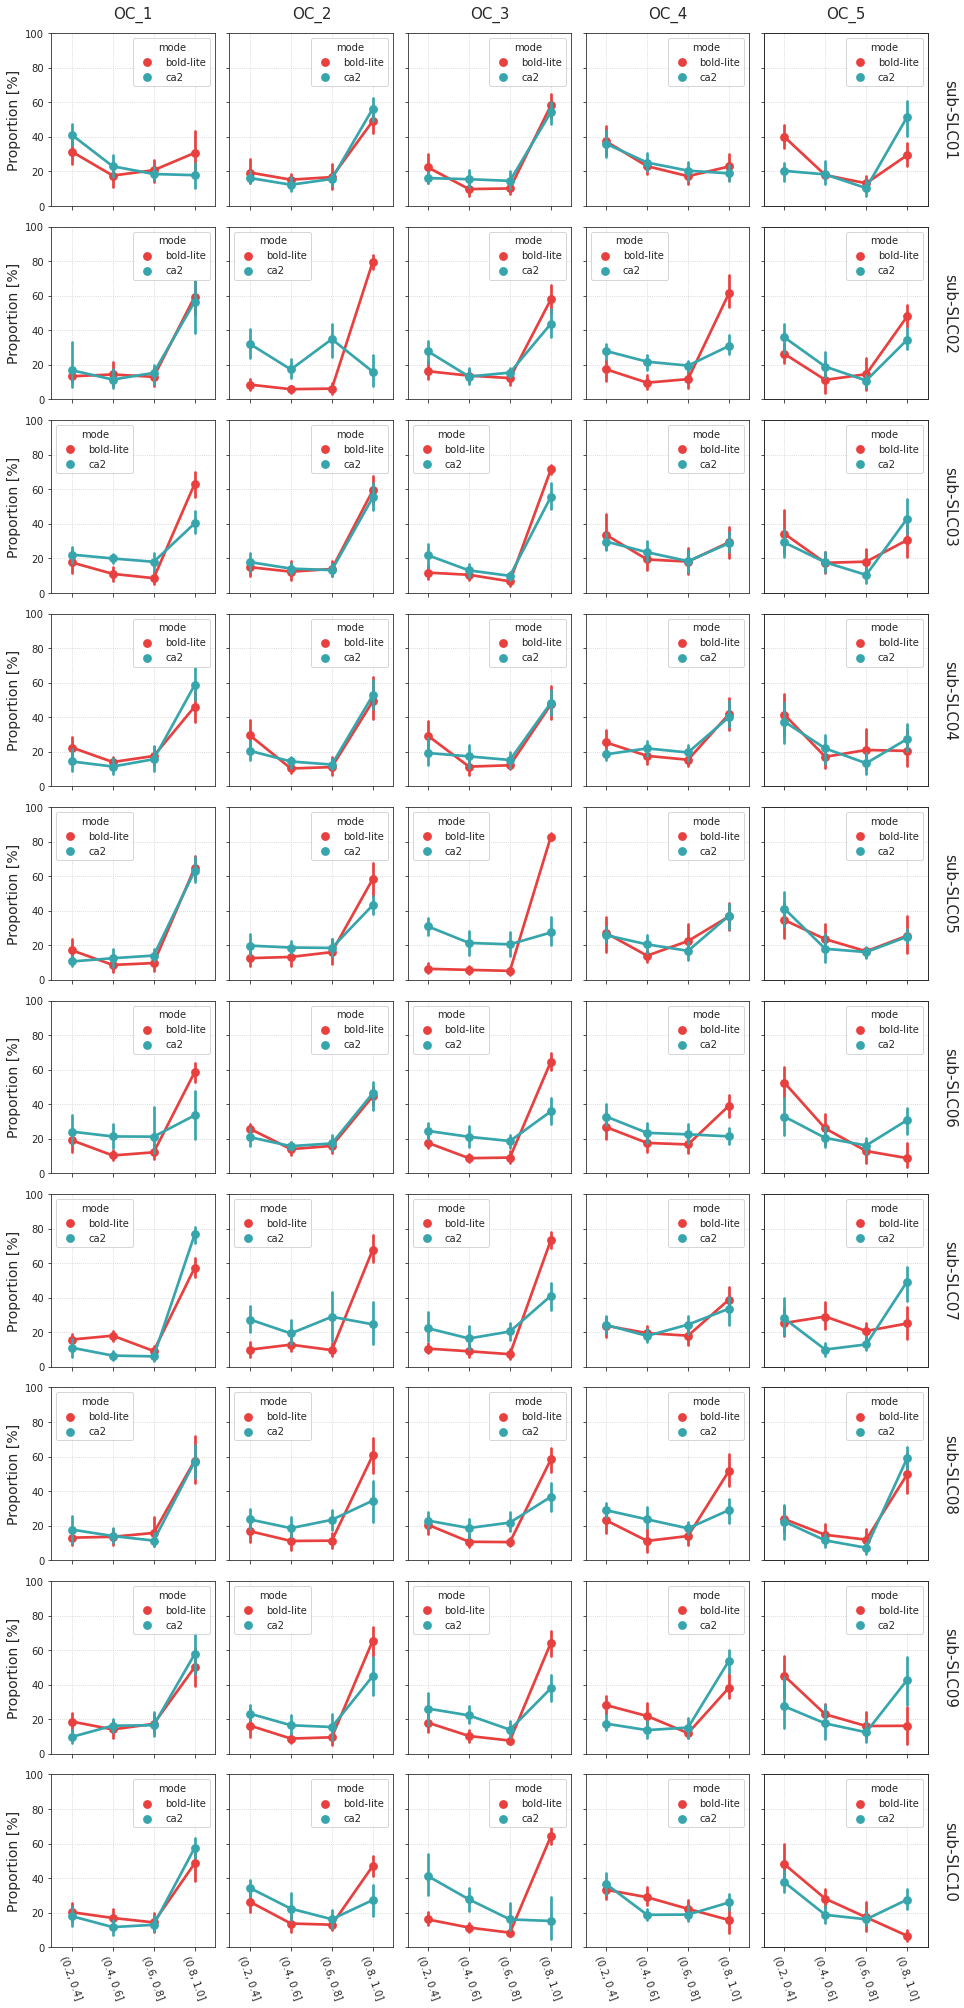

In [34]:
fig, axes = create_figure(10, 5, (13.5, 28), 'all', 'all')

oc_idxs = df['oc_idx'].unique()
for i in range(10):
    for j in range(5):
        ax = axes[i, j]
        _df = df.loc[
            (df['subject'] == i + 1) &
            (df['oc_idx'] == j + 1)
        ]
        sns.pointplot(
            data=_df,
            x='interval',
            y='mean',
            hue='mode',
            ci=99,
            palette=pal,
            ax=ax,
        )
        if i == 0:
            t = f"OC_{j + 1}"
            ax.set_title(t, fontsize=15, y=1.05)
        if j % 5 == 0:
            ylbl = 'Proportion [%]'
        else:
            ylbl = ''
        ax.set_ylabel(ylbl, fontsize=14)
        
        if j == 4:
            axtw = ax.twinx()
            axtw.set_ylabel(mice.get_key(i + 1), fontsize=15, rotation=-90, labelpad=30)
            axtw.yaxis.set_label_position("right")
            axtw.set_yticks([])
        
        ax.tick_params(axis='x', rotation=-70)
        ax.set_xlabel('')
        ax.set_ylim(0, 100)
        ax.grid()
fig.savefig(pjoin(fig_dir, f'indiv_bold+ca2.pdf'), bbox_inches='tight')
plt.show()